In [176]:
from ombre.query import get_nexsci
from ombre import Spectrum, Spectra
from astropy.io import fits
import matplotlib.pyplot as plt
import os
plt.style.use('seaborn-white')
from glob import glob
import numpy as np
import lightkurve as lk
from tqdm import tqdm

In [113]:
fnames = np.sort(np.asarray(glob('results/*_stellar_spectrum.fits')))
f = fnames[np.where(np.asarray([Spectra.from_file(fname)[0].meta['st_teff'] for fname in fnames]) < 4500)]
teff = np.asarray([Spectra.from_file(fname)[0].meta['st_teff'] for fname in f])
s = np.argsort(teff)

y, W, T = [], [], []
label = 'G141'
for idx, fname in enumerate(f[s]):
    hdu = fits.open(fname)
    name = '_'.join(fname.split('/')[1].split('_')[:-2])
    sp = Spectra.from_file(fname)
    k = np.where([v == label for v in sp.visits])[0]
    if len(k) == 0:
        continue
    sp = sp[k].flatten()
    corr = np.median(sp.spec[(sp.wavelength > 1.25*1e4) & (sp.wavelength < 1.35*1e4)])
    y.append(sp.spec/corr)
    W.append(sp.wavelength)
    T.append(np.ones_like(sp.wavelength) * sp.meta['st_teff'])
y, W, T = np.hstack(y), np.hstack(W), np.hstack(T)
s = np.argsort(W)
y, W, T = y[s], W[s], T[s]

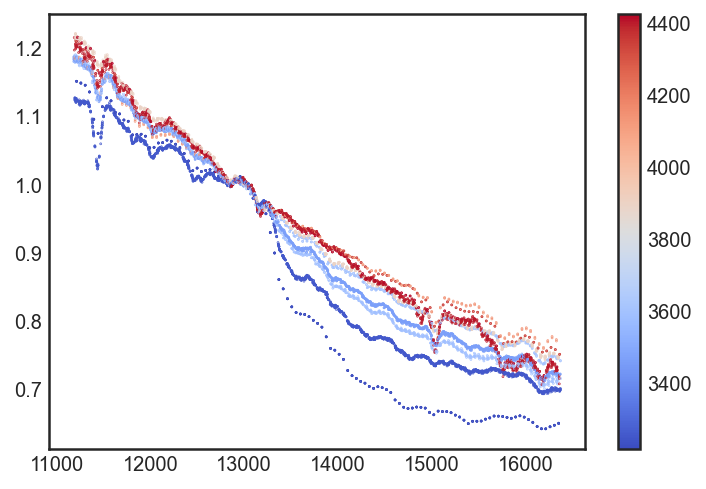

In [114]:
plt.scatter(W, y, s=0.1, c=T, cmap='coolwarm')
plt.colorbar()

In [115]:
# wknots = np.linspace(1.1, 1.7, 150) * 1e4
# tknots = list(np.linspace(teff.min(), teff.max(), 8))[1:-1]

In [116]:
# plt.plot(np.sort(teff), marker='.')
# plt.plot(tknots)

In [117]:
# X1 = lk.designmatrix.create_spline_matrix(np.hstack([wknots.min(), W, wknots.max()]), knots=list(wknots), degree=2).X[1:-1]
# X_teff = lk.designmatrix.create_spline_matrix(T, knots=tknots, degree=2).X
# A = np.hstack([X1[:, idx][:, None] * X_teff for idx in range(X1.shape[1])])
# k = np.isfinite(y)
# sigma_w_inv = A[k].T.dot(A[k]) + np.diag(1/(np.ones(A.shape[1]) * 10000))
# w = np.linalg.solve(sigma_w_inv, A[k].T.dot(y[k]))
# model = A.dot(w)

In [118]:
# plt.scatter(W, model, s=0.1, c=T, cmap='coolwarm')
# plt.colorbar()

In [119]:
# name = 'K2-18'
# sp = Spectra.from_file(f'results/{name}_transmission.fits').flatten()
# sp = sp[np.argsort(sp.wavelength)]
# phot_temp = sp.meta['st_teff']
# spot_temps = np.linspace(phot_temp - 250, phot_temp)[::-1]
# chi1 = np.sum(((sp.spec)**2/sp.spec_err**2))/len(sp.wavelength - 1)
# X2 = lk.designmatrix.create_spline_matrix(np.hstack([wknots.min(), sp.wavelength*1e4, wknots.max()]), knots=list(wknots), degree=2).X[1:-1]
# X_teff = lk.designmatrix.create_spline_matrix(np.hstack([0, (spot_temps[:, None] * np.ones_like(sp.wavelength)).ravel(), 10000]), knots=tknots, degree=2).X[1:-1]
# X_teff = X_teff.reshape((spot_temps.shape[0], sp.wavelength.shape[0], X_teff.shape[-1]))


# spot_area = 0.1
# planet_area = sp.meta['radius']**2/sp.meta['st_rad']**2
# A = np.hstack([X2[:, idx][:, None] * X_teff[0] for idx in range(X2.shape[1])])
# phot_model = A.dot(w)
# for jdx, spot_temp in enumerate(spot_temps):
#     A = np.hstack([X2[:, idx][:, None] * X_teff[jdx] for idx in range(X2.shape[1])])
#     spot_model = A.dot(w)
#     spot_model *= spot_temp**4/phot_temp**4
    
#     oot = (phot_model * (1 - spot_area) + spot_model * spot_area)
#     it = (phot_model * (1 - spot_area - planet_area) + spot_model * spot_area)
#     if jdx == 30:
#         break


In [128]:
wknots = np.linspace(1.1, 1.7, 150) * 1e4
X1 = lk.designmatrix.create_spline_matrix(np.hstack([wknots.min(), W, wknots.max()]), knots=list(wknots), degree=2).X[1:-1]
A = np.hstack([X1, X1*T[:, None], X1*T[:, None]**2])
k = np.isfinite(y)
sigma_w_inv = A[k].T.dot(A[k]) + np.diag(1/(np.ones(A.shape[1]) * 10000))
w = np.linalg.solve(sigma_w_inv, A[k].T.dot(y[k]))
model = A.dot(w)

100%|███████████████████████████████████████████| 50/50 [00:10<00:00,  4.97it/s]
/var/folders/yn/f2r51bxd7pj58243x2y_c6340000gn/T/ipykernel_14930/3259111029.py:37: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(spot_areas, spot_temps, rchi.T, cmap='viridis_r', vmin=rchi.min(), vmax=rchi.min()+0.001)


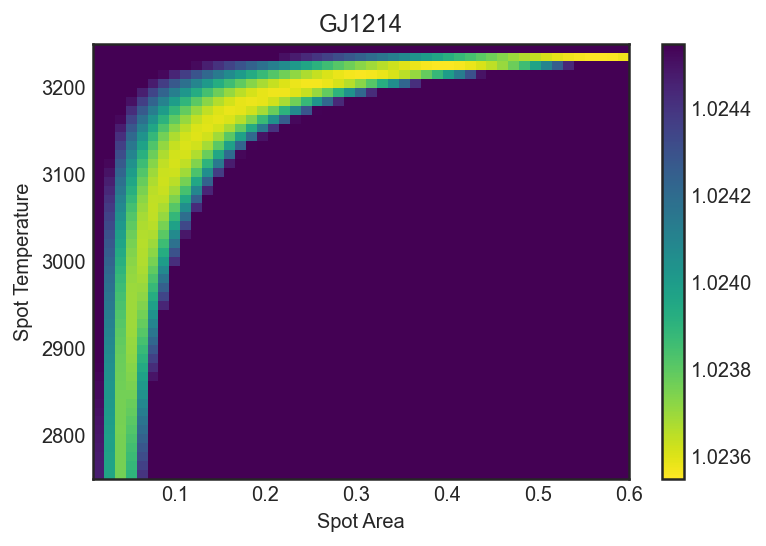

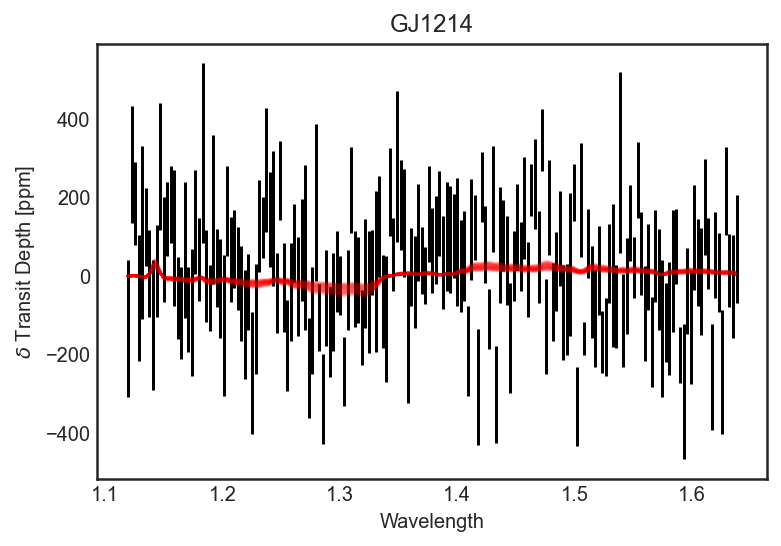

In [177]:
name = 'GJ1214'
sp = Spectra.from_file(f'results/{name}_transmission.fits').flatten()
sp = sp[np.argsort(sp.wavelength)]
chi1 = np.sum(((sp.spec)**2/sp.spec_err**2))/len(sp.wavelength - 1)
X2 = lk.designmatrix.create_spline_matrix(np.hstack([wknots.min(), sp.wavelength * 1e4, wknots.max()]), knots=list(wknots), degree=2).X[1:-1]
phot_temp = sp.meta['st_teff']

spot_temps = np.linspace(phot_temp - 500, phot_temp)[::-1]

#phot_model = np.hstack([X2, X2 * phot_temp, X2 * phot_temp**2]).dot(w)
#spot_model = np.hstack([X1, X1 * spot_temp, X1 * spot_temp**2]).dot(w)


spot_model = np.vstack([np.hstack([X2, X2 * spot_temp, X2 * spot_temp**2]).dot(w) for spot_temp in spot_temps]).T
#spot_model *= spot_temps**4/phot_temp**4
spot_areas = np.linspace(0.01, 0.6, 50)
rchi = np.zeros((spot_areas.shape[0], spot_temps.shape[0]))
ts_models = np.zeros((spot_areas.shape[0], spot_temps.shape[0], sp.wavelength.shape[0]))
planet_area = sp.meta['radius']**2/sp.meta['st_rad']**2
for idx, spot_area in enumerate(tqdm(spot_areas)):
    
    phot_temps = (sp.meta['st_teff'] - (spot_area * spot_temps))/(1 - spot_area)
    phot_model = np.vstack([np.hstack([X2, X2 * phot_temp, X2 * phot_temp**2]).dot(w) for phot_temp in phot_temps]).T
    ###spot_model *= spot_temps**4/phot_temp**4

    #oot = (phot_model[:, None] * (1 - spot_area) + spot_model * spot_area)
    #it = (phot_model[:, None] * (1 - spot_area - planet_area) + spot_model * spot_area)
    oot = (phot_model * (1 - spot_area) + spot_model * spot_area * spot_temps**4/phot_temps**4)
    it = (phot_model * (1 - spot_area - planet_area) + spot_model * spot_area * spot_temps**4/phot_temps**4)
    ts_model = ((oot - it)/oot - planet_area)
    #This is a hack I shouldn't do
    ts_model -= np.mean(ts_model, axis=0)
    rchi[idx] = np.sum((sp.spec[:, None] - ts_model*1e6)**2/sp.spec_err[:, None]**2, axis=0)/(sp.spec.shape[0] - 3)
    ts_models[idx] = ts_model.T    


plt.pcolormesh(spot_areas, spot_temps, rchi.T, cmap='viridis_r', vmin=rchi.min(), vmax=rchi.min()+0.001)
plt.colorbar()
plt.xlabel('Spot Area')
plt.ylabel("Spot Temperature")
plt.title(name)

if len(sp.wavelength) > 600:
    ax = sp.bin(np.linspace(1.1, 1.7, 200)).plot(ls='', c='k', label='HST WFC3 data', zorder=-1)
else:
    ax = sp.plot(ls='', c='k', label='HST WFC3 data', zorder=-1)
l = np.asarray(np.where(rchi < chi1)).T
if len(l) != 0:
    ax.plot(sp.wavelength[np.argsort(sp.wavelength)], 1e6 * ts_models[l[:, 0], l[:, 1]].T[np.argsort(sp.wavelength)], c='r', alpha=0.01);

    #ax.scatter(sp.wavelength, 1e6*ts_model[:, l[1]], color='C3', zorder=1, label=f'Spot Model. Area:{np.round(spot_area, 2)}, SpotTemp:{int(spot_temp)}K')
    ax.set(title=name)


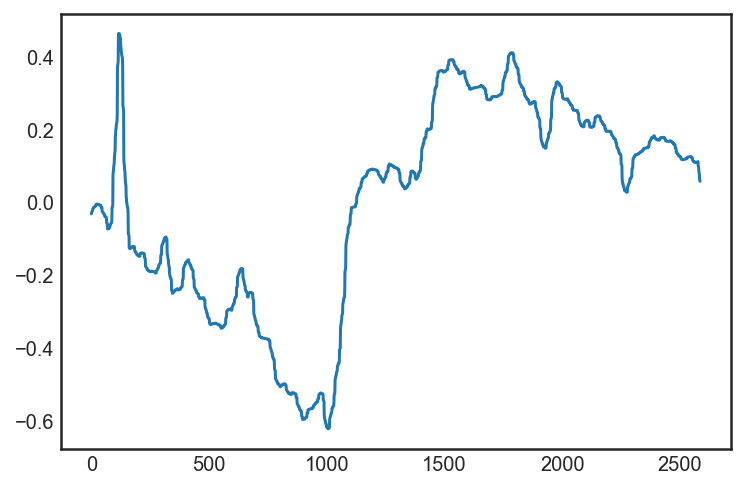

In [141]:
aT = sA * sT + (1 - sA) * stT

NameError: name 'sA' is not defined

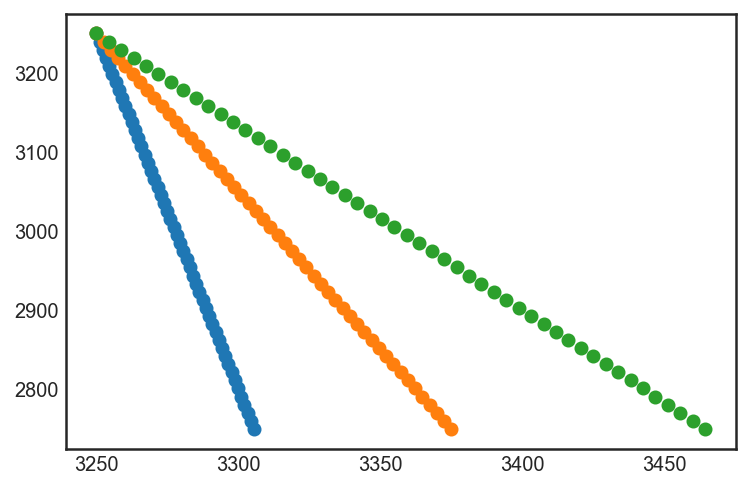

In [154]:
spot_area = 0.1
phot_temps = (sp.meta['st_teff'] - (spot_area * spot_temps))/(1 - spot_area)
plt.scatter(phot_temps, spot_temps)

spot_area = 0.2
phot_temps = (sp.meta['st_teff'] - (spot_area * spot_temps))/(1 - spot_area)
plt.scatter(phot_temps, spot_temps)

spot_area = 0.3
phot_temps = (sp.meta['st_teff'] - (spot_area * spot_temps))/(1 - spot_area)
plt.scatter(phot_temps, spot_temps)


In [132]:
sp.meta['st_teff']

3250.0

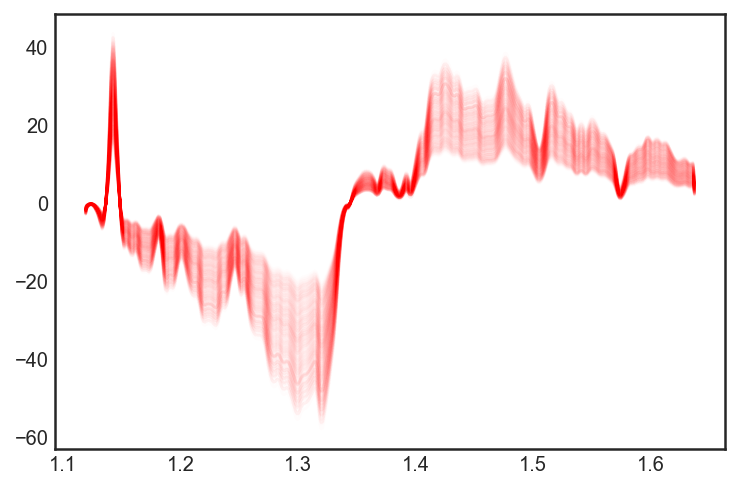

In [130]:
plt.plot(sp.wavelength[np.argsort(sp.wavelength)], 1e6 * ts_models[l[:, 0], l[:, 1]].T[np.argsort(sp.wavelength)], c='r', alpha=0.01);

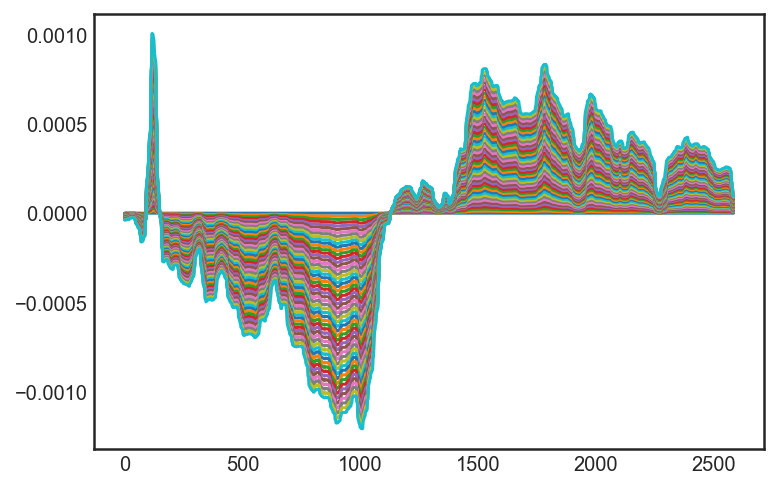

In [107]:
plt.plot(ts_model);

/var/folders/yn/f2r51bxd7pj58243x2y_c6340000gn/T/ipykernel_13692/2186759447.py:1: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(spot_areas, spot_temps, rchi.T, cmap='viridis_r', vmin=rchi.min(), vmax=rchi.min()*1.001)


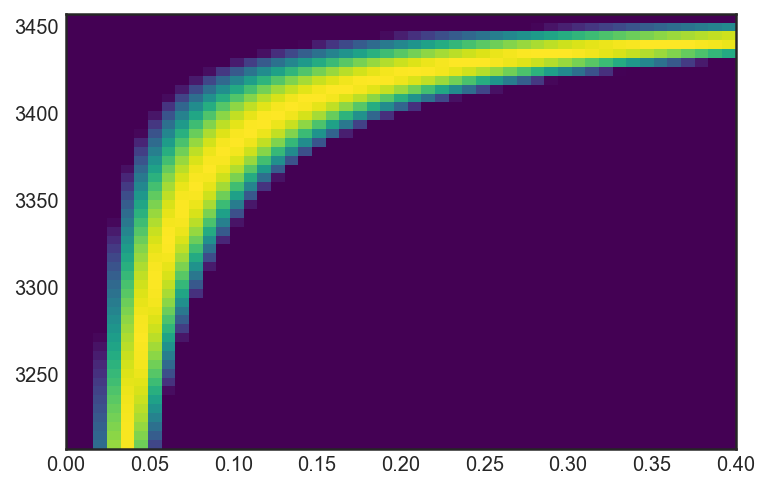

In [101]:
plt.pcolormesh(spot_areas, spot_temps, rchi.T, cmap='viridis_r', vmin=rchi.min(), vmax=rchi.min()*1.001)

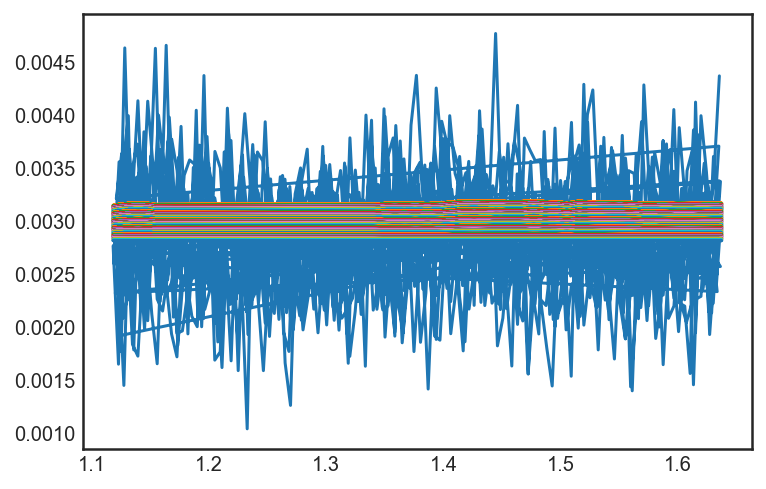

In [37]:
plt.plot(sp.wavelength, sp.depth + sp.spec * 1e-6)
plt.plot(sp.wavelength, ((oot - it)/oot));

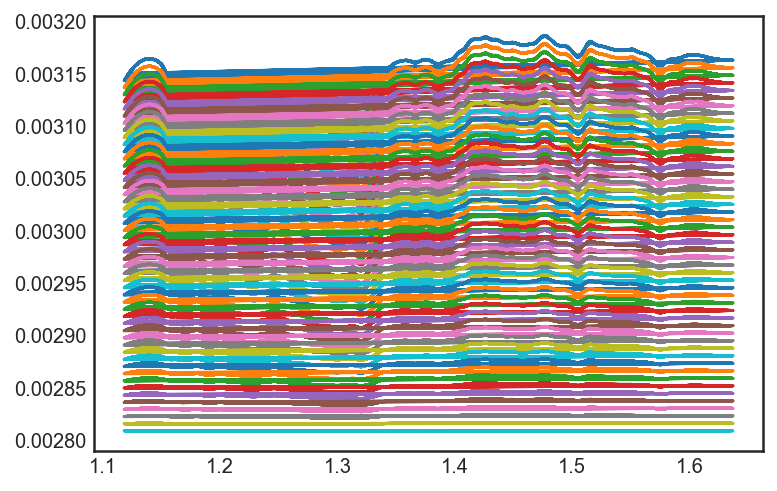

/var/folders/yn/f2r51bxd7pj58243x2y_c6340000gn/T/ipykernel_13692/1470764279.py:1: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(sp.wavelength, spot_temps, ((oot - it)/oot).T)


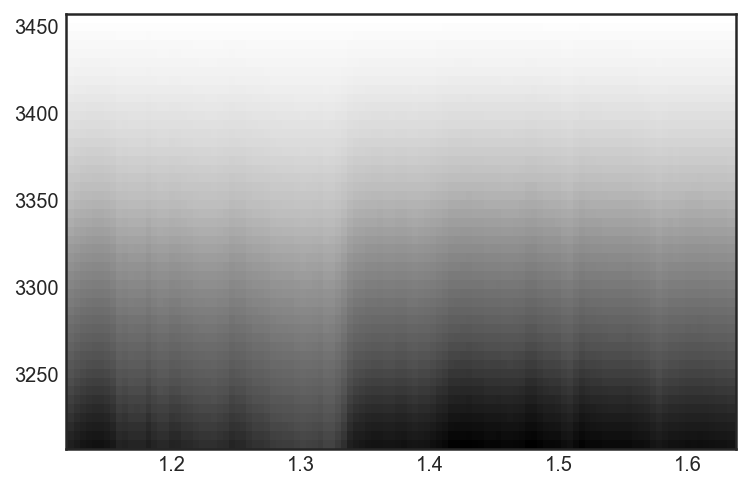

In [20]:
plt.pcolormesh(sp.wavelength, spot_temps, ((oot - it)/oot).T)

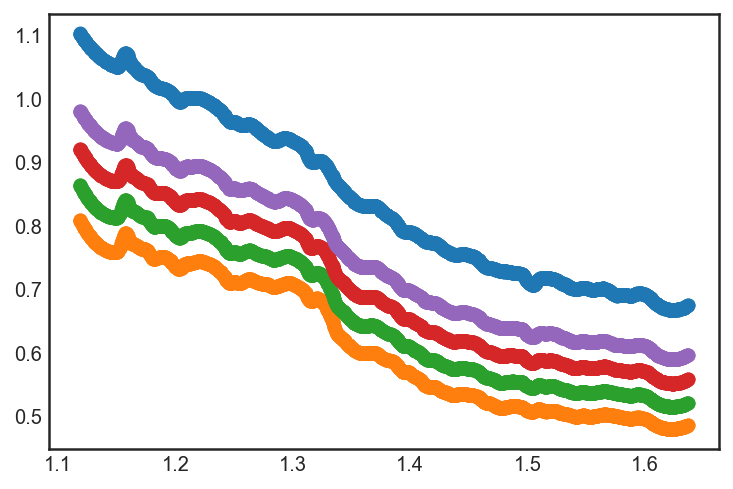

In [13]:
plt.scatter(sp.wavelength, phot_model)
plt.scatter(sp.wavelength, spot_model[:, 0])
plt.scatter(sp.wavelength, spot_model[:, 10])
plt.scatter(sp.wavelength, spot_model[:, 20])
plt.scatter(sp.wavelength, spot_model[:, 30])

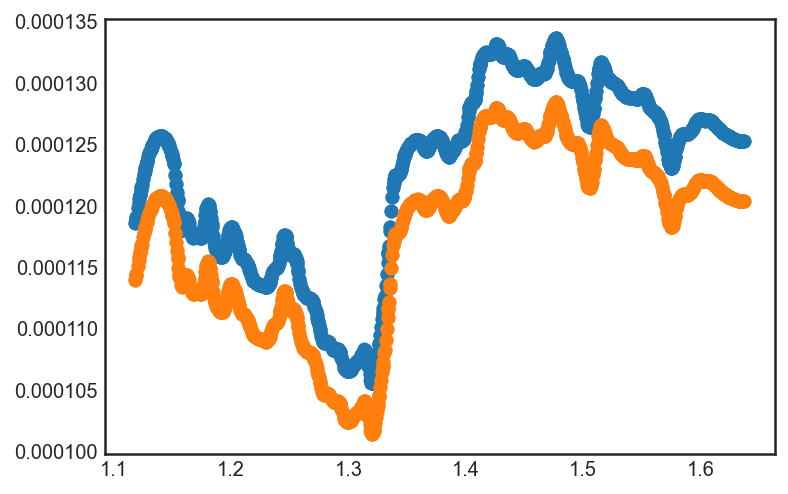

In [580]:
plt.scatter(sp.wavelength, ts_models[20, 25]);
plt.scatter(sp.wavelength, ts_models[20, 26]);

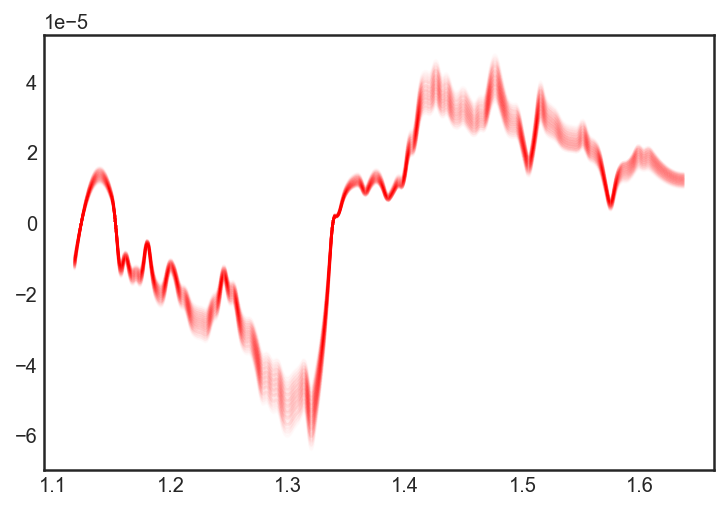

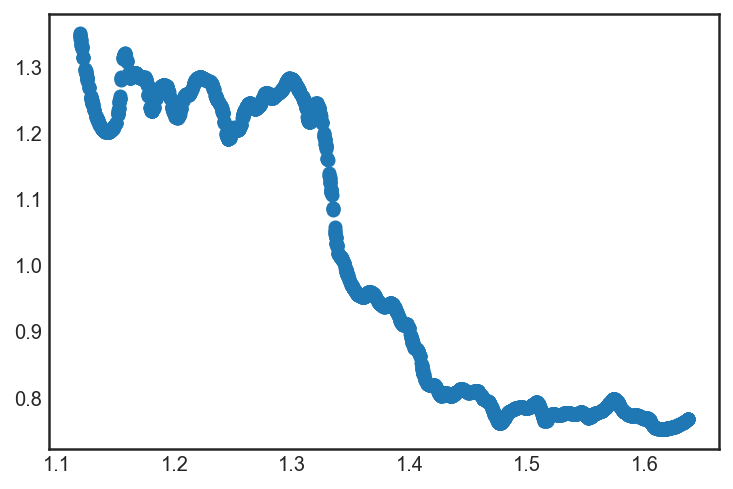

In [372]:
plt.scatter(sp.wavelength, spot_model[:, 0])

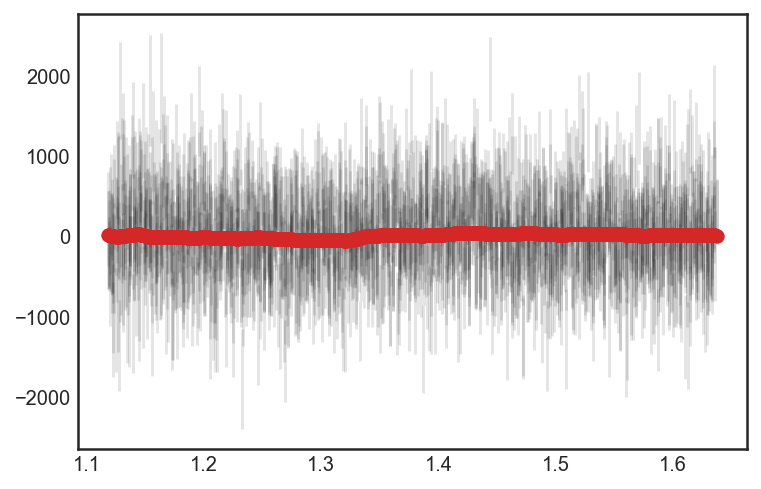

In [295]:
plt.errorbar(sp.wavelength, sp.spec, sp.spec_err, zorder=-1, c='k', alpha=0.1, ls='')
plt.scatter(sp.wavelength, 1e6*ts_model[:, l[1]], color='C3', zorder=1)

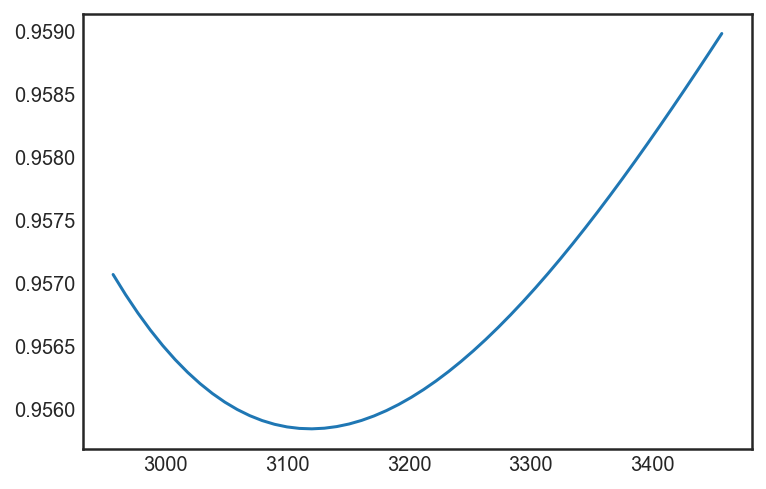

In [239]:
plt.plot(spot_temps, rchi)

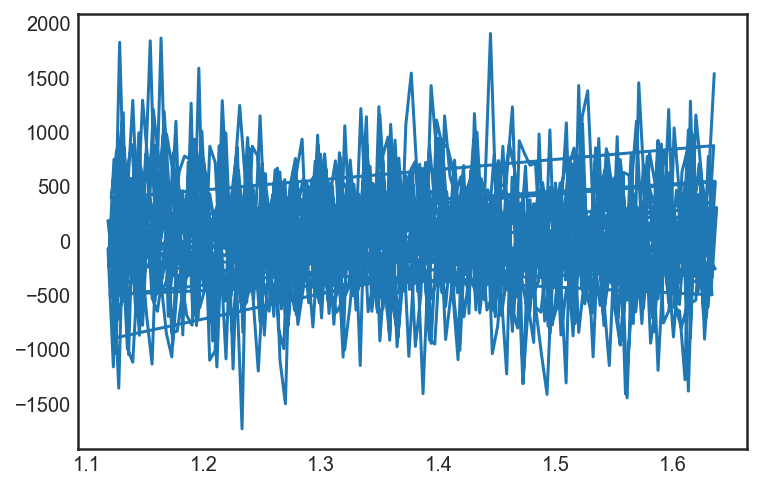

In [236]:
plt.plot(sp.wavelength, sp.spec - ts_model[:, 0]*1e6)

/var/folders/yn/f2r51bxd7pj58243x2y_c6340000gn/T/ipykernel_11490/3364359698.py:1: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(sp.wavelength, spot_temps, ts_model.T)


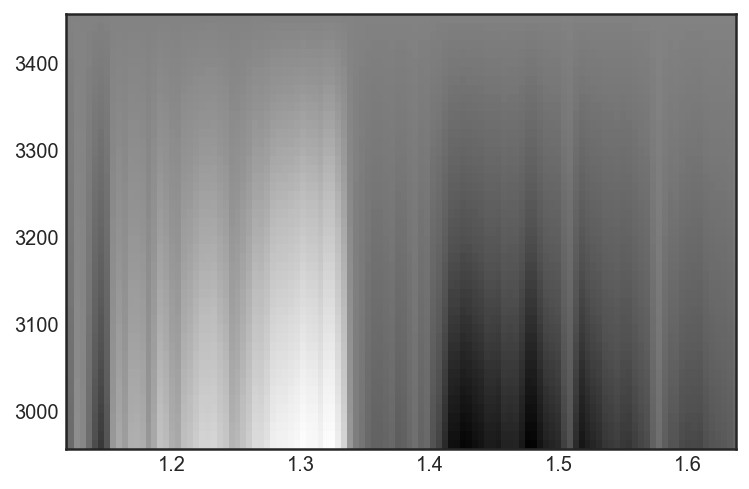

In [212]:
plt.pcolormesh(sp.wavelength, spot_temps, ts_model.T)

In [197]:
sp

Spectrum [Visit 1]

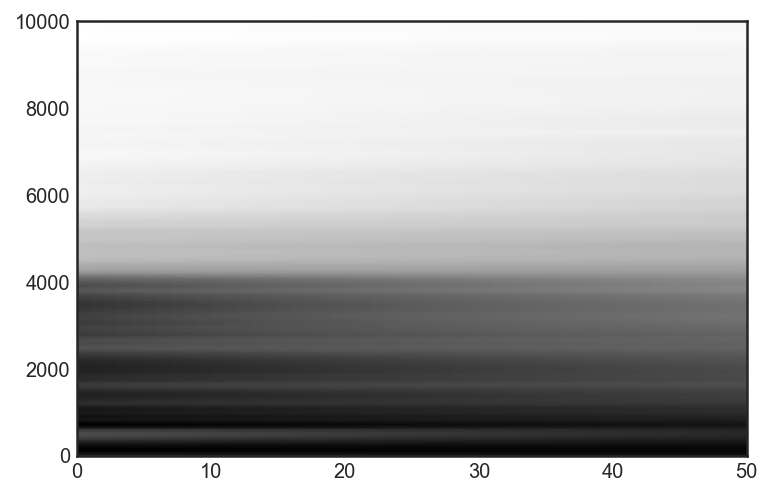

In [175]:
plt.pcolormesh(X2)

In [165]:
sp.wavelength, sp.spec, sp.spec_err

(array([1.11830335, 1.12289971, 1.12749606, ..., 1.62581804, 1.63041417,
        1.63501031]),
 array([  -48.97506071, -1164.73413407,   658.4809766 , ...,
           49.04822779,   625.50992029,  1554.80875698]),
 array([613.0276668 , 592.97223535, 596.28230923, ..., 576.37764896,
        578.52227718, 581.80290361]))

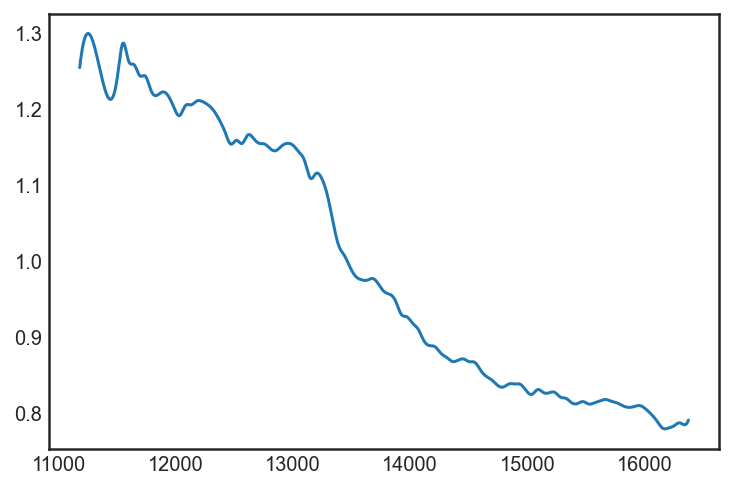

In [158]:
plt.plot(W[::10], model1[::10])

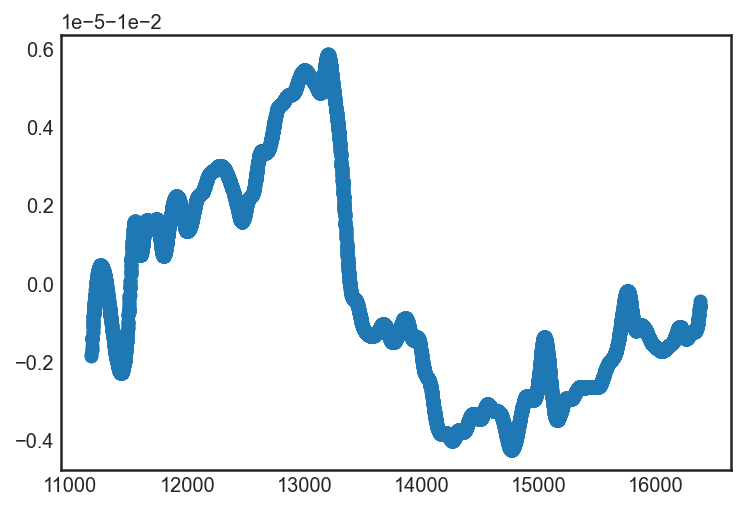

In [ ]:
plt.scatter(W, T, c=y - model)

In [332]:


wav = np.linspace(1.1, 1.65, 100) * 1e4
ar = np.zeros((len(s), len(wav) - 1))
ar_err = np.zeros((len(s), len(wav) - 1))
label = 'G141'
for idx, fname in enumerate(f[s]):
    hdu = fits.open(fname)
    name = '_'.join(fname.split('/')[1].split('_')[:-2])
    sp = Spectra.from_file(fname)
    k = np.where([v == label for v in sp.visits])[0]
    if len(k) == 0:
        continue
    sp = sp[k].flatten()
    ar[idx] = sp.bin(wav).spec
    ar_err[idx] = sp.bin(wav).spec_err
wav = wav[:-1] + np.median(np.diff(wav))/2
ar /= np.nanmean(ar[:, :10], axis=1)[:, None]

In [123]:
dar = np.diff(ar, axis=1)
dar_err = np.hypot(ar_err[:, :-1], ar_err[:, 1:])

array([[1.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.37581916, 0.52413707, 0.09644939, ..., 0.        , 0.        ,
        0.        ],
       [0.08711444, 0.57740943, 0.30672103, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.30672103, 0.57740943,
        0.08711444],
       [0.        , 0.        , 0.        , ..., 0.09644939, 0.52413707,
        0.37581916],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        1.        ]])

In [326]:
#X, Y = np.meshgrid(wav[:-1] + np.median(np.diff(wav))/2, teff)
#A = np.vstack([X.ravel()**idx * Y.ravel()**jdx for idx in np.arange(0, 5) for jdx in np.arange(0, 2)]).T
X = lk.designmatrix.create_spline_matrix(wav[:-1], n_knots=60, degree=1).X
A = np.vstack([(X[:, idx] * teff[:, None]**jdx).ravel() for jdx in np.arange(0, 3) for idx in range(X.shape[1])]).T




In [327]:
k = np.isfinite(dar_err.ravel()) & np.isfinite(dar.ravel())
sigma_w_inv = A[k].T.dot(A[k]/dar_err.ravel()[k][:, None]**2) + np.diag(1/(np.ones(A.shape[1]) * 10000))
w = np.linalg.solve(sigma_w_inv, A[k].T.dot(dar.ravel()[k]/dar_err.ravel()[k]**2))
model = A.dot(w).reshape(dar.shape)

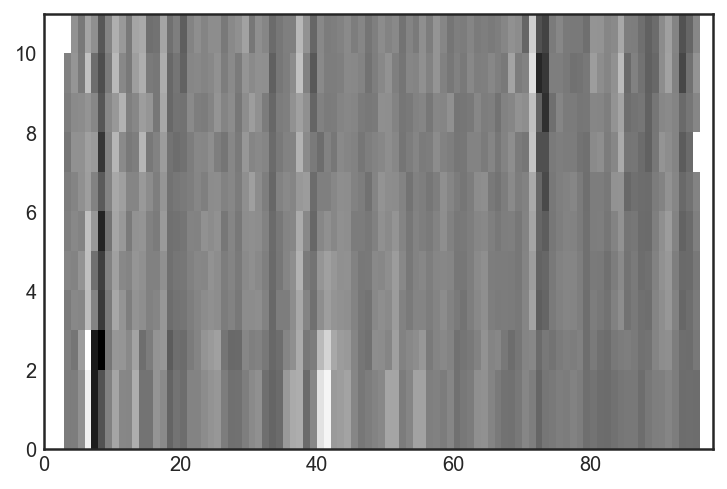

In [328]:
plt.pcolormesh(dar)

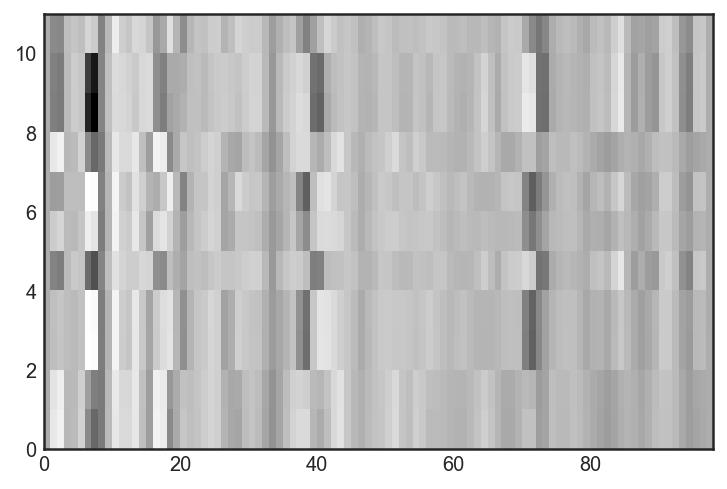

In [331]:
plt.pcolormesh(model)

(-0.06, 0.06)

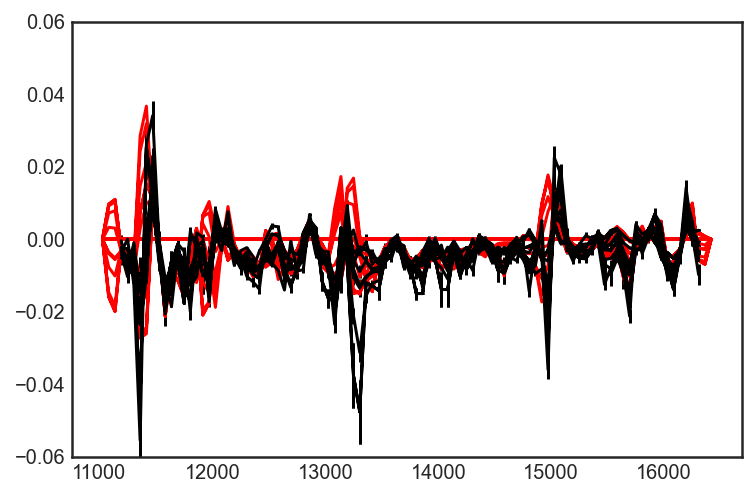

In [330]:
plt.errorbar((wav[:-1][None, :] * np.ones(dar.shape)).ravel(), dar.ravel(), dar_err.ravel(), c='k');
plt.plot((wav[:-1][None, :] * np.ones(dar.shape)).ravel(), model.ravel(), c='r');
plt.ylim(-0.06, 0.06)

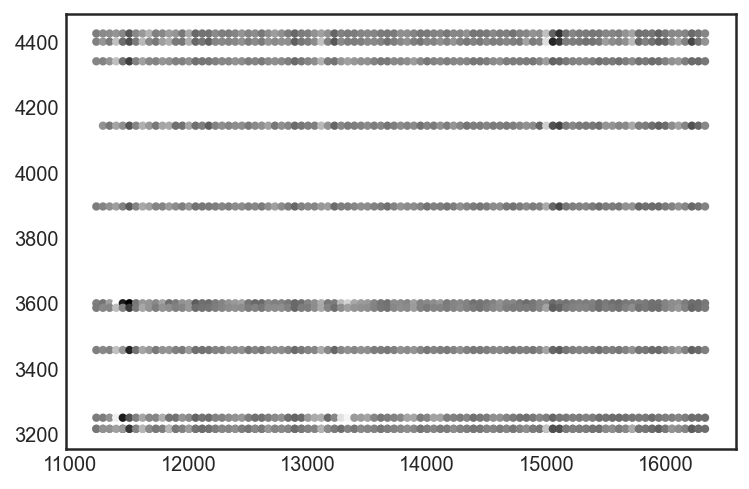

In [103]:
plt.scatter(*np.meshgrid(wav[:-1] + np.median(np.diff(wav))/2, teff),  c=np.diff(ar, axis=1), s=10)

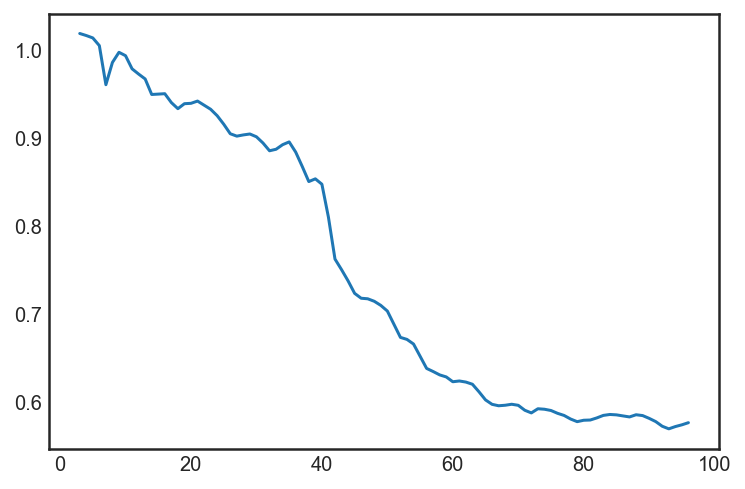

In [85]:
plt.plot(ar[0])

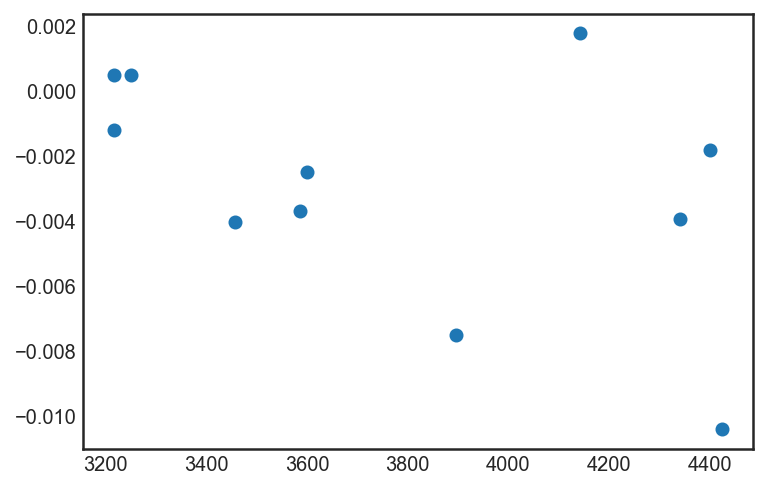

In [91]:
plt.scatter(teff, np.diff(ar, axis=1)[:, 15])